In [310]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt  
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve # ROC a diferencia del accuracy te da un valor justo de precision para datos desbalanceados

In [311]:
df = pd.read_csv('dataset/new_data/df_time_features.csv')

In [312]:
df['target'] = df['target'].astype(int)

In [313]:
df.dtypes

mean            float64
max             float64
min             float64
std             float64
rms             float64
skewness        float64
kurtosis        float64
crest_factor    float64
form_factor     float64
target            int64
dtype: object

In [314]:
df.head()

,mean,max,min,std,rms,skewness,kurtosis,crest_factor,form_factor,target
0,-0.018963,0.142822,-0.091016,0.029629,0.035176,0.754447,0.790247,4.060180,-1.855001,1
1,-0.096633,0.284885,-0.325495,0.107155,0.144287,0.131053,-0.892353,1.974430,-1.493142,1
2,-0.030544,0.156420,-0.132173,0.041449,0.051486,0.564729,0.138655,3.038136,-1.685602,1
3,-0.060276,0.225913,-0.218432,0.069759,0.092190,0.406804,-0.322002,2.450524,-1.529453,1
4,-0.044948,0.176934,-0.150896,0.048619,0.066211,0.632929,0.339129,2.672289,-1.473038,1


In [315]:
df_as = pd.concat([df],axis=0)

In [316]:
df_as.shape

(102, 10)

In [317]:
df.loc[0,df.columns[1:]].tolist()

[0.142822,
 -0.091016,
 0.0296291150155779,
 0.0351762743654415,
 0.754447293825355,
 0.7902467185117055,
 4.060179839292865,
 -1.855001335083006,
 1.0]

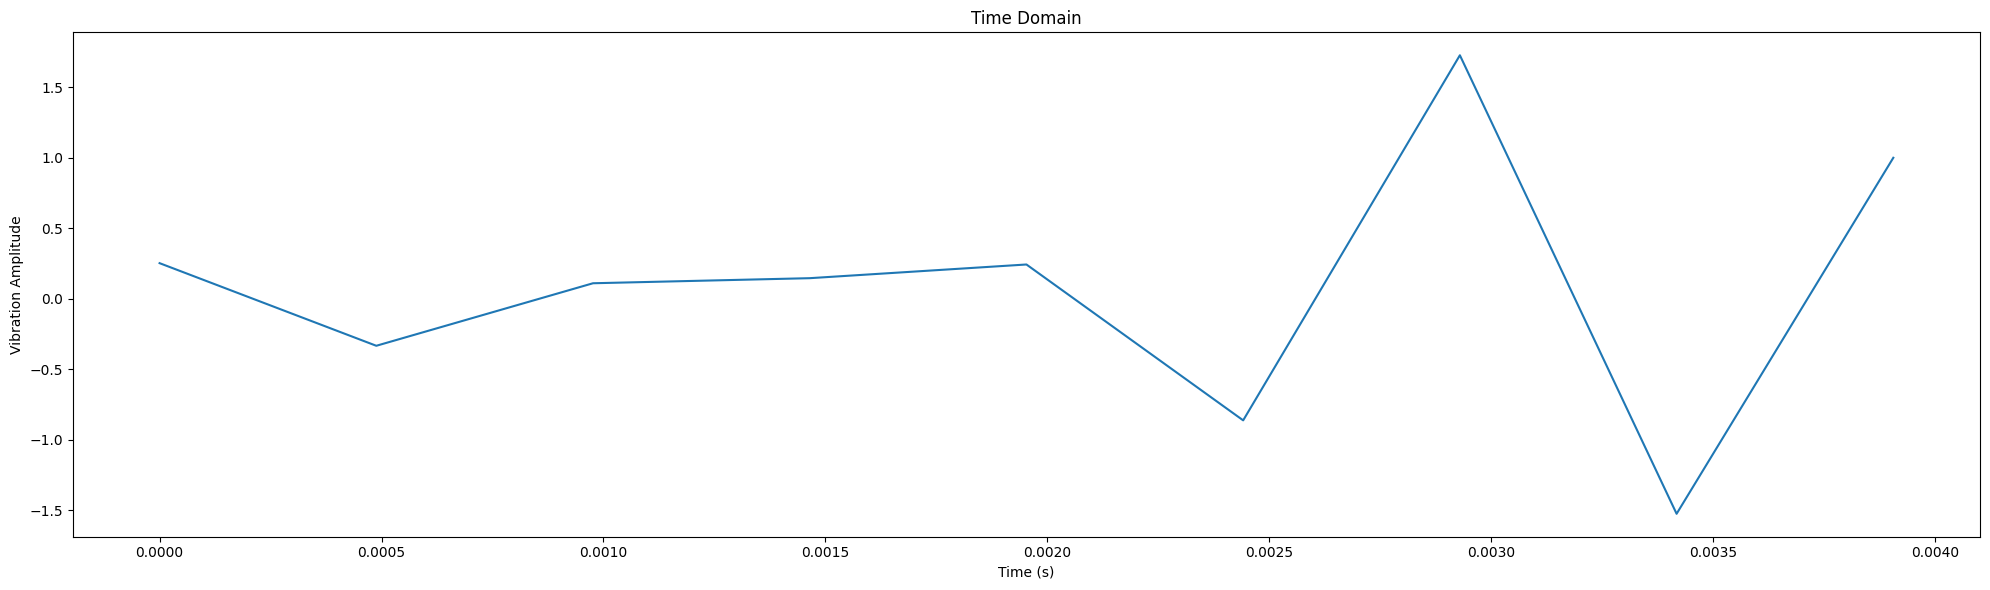

In [318]:
# Load your vibration data from a CSV file
# Assume the CSV file has a single column of vibration data with a header
# data = pd.read_csv('vibration_data.csv')

y = np.array(df.loc[6,df.columns[1:]].tolist())
# vibration_data = data['Vibration'].values
vibration_data = y
# Time parameters
sampling_rate = 2048  # Hz, example sampling rate
n = len(vibration_data)
time = np.arange(n) / sampling_rate

# Perform FFT
freq_domain = np.fft.fft(vibration_data)
freq = np.fft.fftfreq(n, d=1/sampling_rate)

x_freq = freq[:n//2]
y_freq = np.abs(freq_domain)[:n//2] * 1/n


# Plot the results
plt.figure(figsize=(20,6))

plt.plot(time, vibration_data)
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Vibration Amplitude')


plt.tight_layout()
plt.show()

In [319]:
# Standardize the features
X = df_as.drop("target", axis=1) 
y = df_as["target"]
# Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [320]:
# from sklearn.datasets import load_iris
# from sklearn.decomposition import PCA
# import pandas as pd

# # Create a PCA object to reduce the dimensionality to 2 components
# pca = PCA(n_components=80)

# # Fit the PCA model to the data
# pca.fit(X)

# # Transform the data to the new lower-dimensional space
# X_pca = pca.transform(X)

# # Create a Pandas DataFrame from the transformed data
# df_as = pd.DataFrame(data=X_pca, columns= [str(i) for i in range(80)])
# df_as['target'] = y

# # Print the first few rows of the DataFrame
# print(df_as.head())

# X = df_as.drop("target", axis=1) 
# y = df_as["target"]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [321]:
X_train.head()

,mean,max,min,std,rms,skewness,kurtosis,crest_factor,form_factor
53,-0.054407,0.575915,-0.196471,0.072851,0.090921,1.891975,6.607211,6.334201,-1.671128
22,-0.017739,0.215652,-0.097674,0.038837,0.042694,1.066305,1.773790,5.051066,-2.406790
68,-0.054217,0.950194,-0.190584,0.095369,0.109698,3.798787,22.320691,8.661903,-2.023320
44,-0.021407,0.256432,-0.125351,0.048604,0.053107,1.120425,1.814069,4.828612,-2.480771
98,-0.140438,0.852626,-0.481869,0.219163,0.260287,1.235430,1.164436,3.275713,-1.853398


In [322]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(81, 9)
(21, 9)
(81,)
(21,)


In [323]:
pd.DataFrame(y_train).groupby('target').agg({'target':['count']})

,target
,count
target,
0,43
1,38


In [324]:
def apply_classifier(clf,xTrain,xTest,yTrain,yTest):

    clf.fit(xTrain, yTrain) #Entrenamiento del modelo
    predictions = clf.predict(xTest) #Validación sobre la data de testing
    conf_mtx = confusion_matrix(yTest,predictions) #Matriz de confusión de la data de testing real con la predicha

    f, axes = plt.subplots(ncols=2, figsize=(15, 5)) #Definición del área de visualización (2 gráficas)

    sns.heatmap(conf_mtx,annot=True,cbar = False,fmt = "g",ax = axes[0])#definición del formato de la matriz de confusión
    axes[0].set_xlabel('Predicted labels') #Titulo del eje x de la matriz de confusión
    axes[0].set_ylabel('True labels') #Titulo del eje y de la matriz de confusión
    axes[0].set_title('Confusion Matrix Test'); #Titulo de la matriz de confusión
    axes[0].xaxis.set_ticklabels(['Not Fault', 'Fault']); #distribución de los resultados en la matriz de confusión del eje x
    axes[0].yaxis.set_ticklabels(['Not Fault', 'Fault']); #distribución de los resultados en la matriz de confusión del eje y

    print(classification_report(yTest,predictions)) #mostrar resultados

    roc_auc = roc_auc_score(yTest,predictions) #definición del cálculo del auc
    print ("AUC ROC : ",roc_auc) #mostrar el resultado

    fpr, tpr,_ = roc_curve(yTest, predictions) #Función para armar la curva ROC
    #fpr : false positive rate
    #tpr : true positive rate
    axes[1].plot(fpr,tpr,label= "auc="+str(roc_auc)); #código para mostrar el resultado del auc en la gráfica
    axes[1].plot([0, 1], [0, 1]) #código del formato de la gráfica
    plt.xlabel('False Positive Rate') #título del eje x
    plt.ylabel('True Positive Rate') #título del eje y
    plt.title('ROC') #título del gráfico

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        13

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

AUC ROC :  1.0


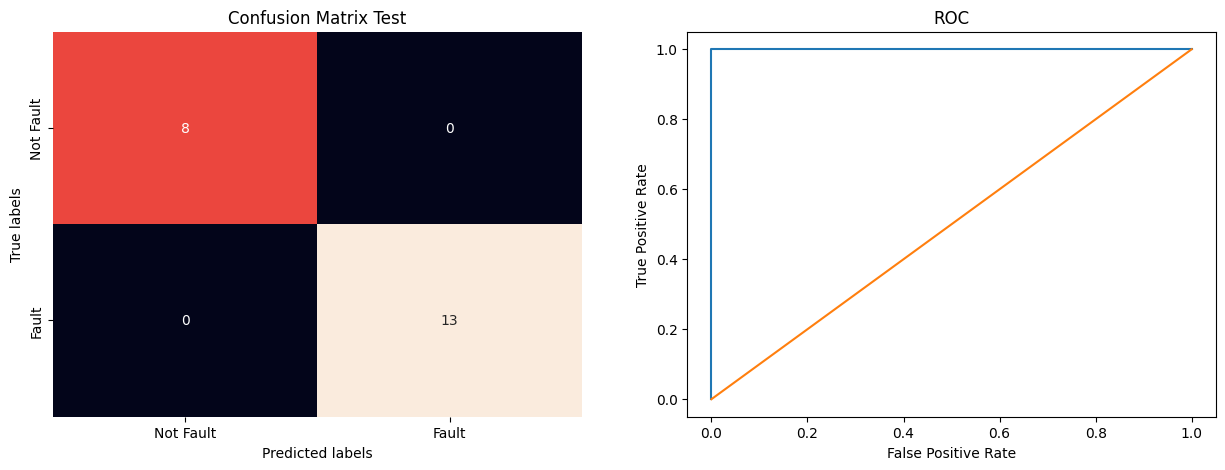

In [325]:
decision_tree = DecisionTreeClassifier() # Definir nuestro modelo
apply_classifier(decision_tree,X_train, X_test, y_train, y_test) # Aplicar la funcion que hemos construido

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        13

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

AUC ROC :  1.0


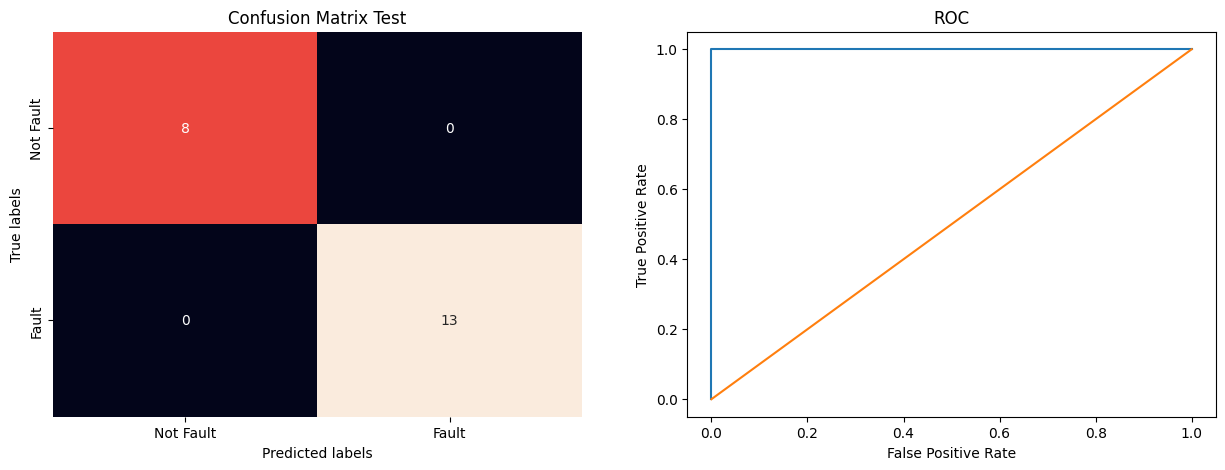

In [326]:
logistic_reg = LogisticRegression()
apply_classifier(logistic_reg,X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        13

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

AUC ROC :  1.0


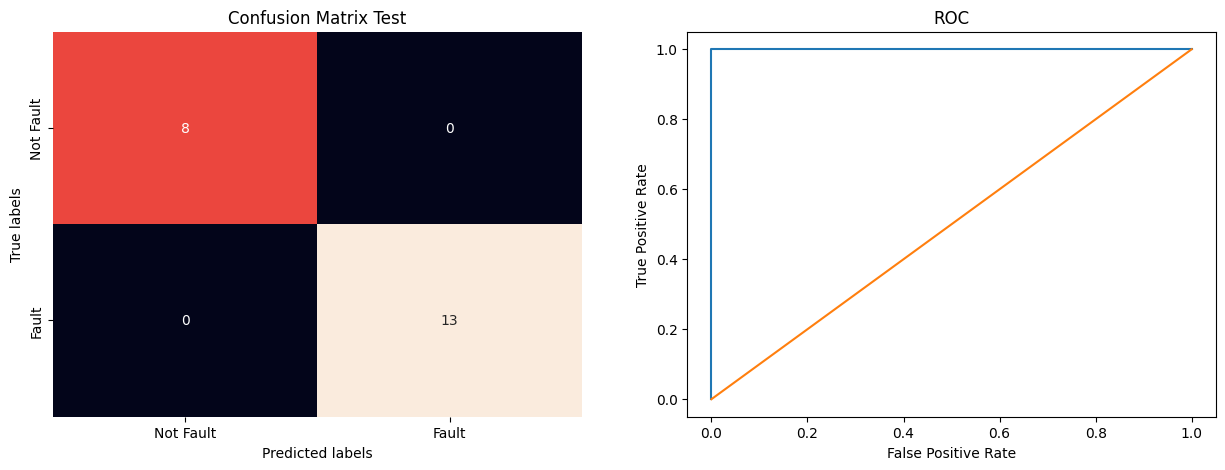

In [327]:
random_forest = RandomForestClassifier(random_state = 42)
apply_classifier(random_forest,X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        13

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

AUC ROC :  1.0


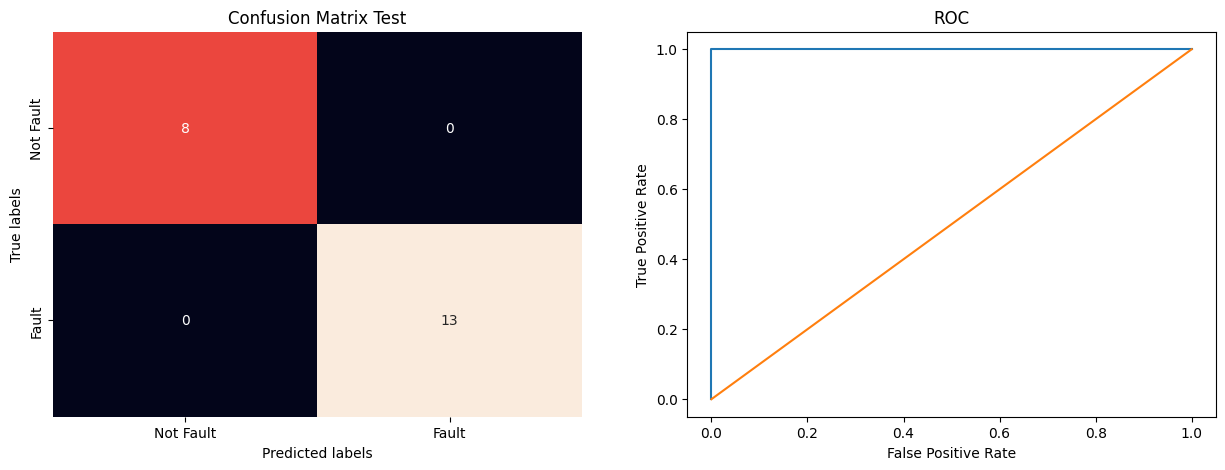

In [328]:
xg_boost = XGBClassifier()
apply_classifier(xg_boost,X_train, X_test, y_train, y_test)

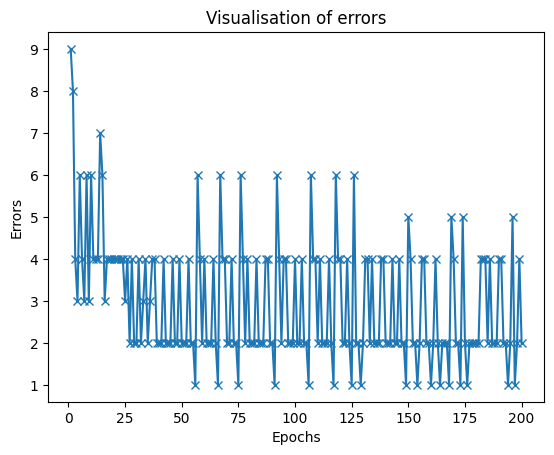

In [329]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


class Perceptron(object):
    """ Perceptron for demonstrating a binary classifier """

    def __init__(self, learn_rate = 0.01, iterations = 100):
        self.learn_rate = learn_rate
        self.iterations = iterations


    def fit(self, X, y, biased_X = True):
        """ Fit training data to our model """
        X = self._add_bias(X)
        self._initialise_weights(X)

        self.errors = []

        for cycle in range(self.iterations):
            trg_error = 0
            for x_i, output in zip(X, y):
                output_pred = self.predict(x_i, biased_X=True)
                trg_update = self.learn_rate * (output - output_pred)
                self.weights += trg_update * x_i
                trg_error += int(trg_update != 0.0)
            self.errors.append(trg_error)

        return self


    def _net_input(self, X):
        """ Net input function (weighted sum) """
        """ print(self.weights)  """
        return np.dot(X, self.weights)


    def predict(self, X, biased_X=False):
        """ Make predictions for the given data, X, using unit step function """
        if not biased_X:
            X = self._add_bias(X)
        return np.where(self._net_input(X) >= 0.0, 1, 0)


    def _add_bias(self, X):
        """ Add a bias column of 1's to our data, X """
        bias = np.ones((X.shape[0], 1))
        biased_X = np.hstack((bias, X))
        return biased_X


    def _initialise_weights(self, X):
        """ Initialise weigths - normal distribution sample with standard dev 0.01 """
        random_gen = np.random.RandomState(1)
        self.weights = random_gen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        return self


# create a perceptron classifier and train on our data
classifier = Perceptron(learn_rate = 0.001, iterations = 200)
classifier.fit(X_train, y_train)

# plot our misclassification error after each iteration of training
plt.plot(range(1, len(classifier.errors) + 1), classifier.errors, marker = 'x')
plt.title("Visualisation of errors")
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.show()

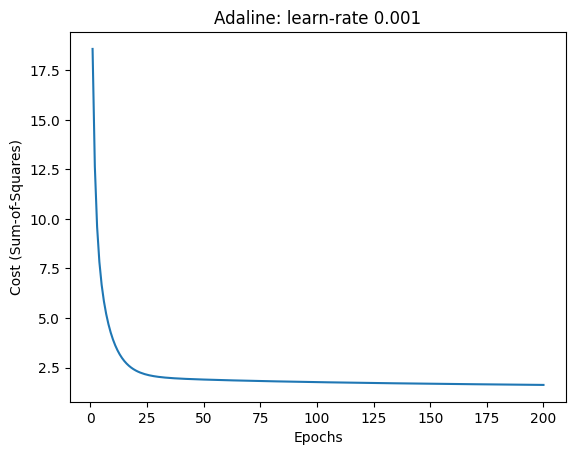

In [330]:
class Adaline(object):
    """ Adaline (Adaptive Linear Neuron) for binary classification.
        Minimises the cost function using gradient descent. """

    def __init__(self, learn_rate = 0.01, iterations = 100):
        self.learn_rate = learn_rate
        self.iterations = iterations


    def fit(self, X, y, biased_X = False, standardised_X = False):
        """ Fit training data to our model """
        if not standardised_X:
            X = self._standardise_features(X)
        if not biased_X:
            X = self._add_bias(X)
        self._initialise_weights(X)
        self.cost = []

        for cycle in range(self.iterations):
            output_pred = self._activation(self._net_input(X))
            errors = y - output_pred
            self.weights += (self.learn_rate * X.T.dot(errors))
            cost = (errors**2).sum() / 2.0
            self.cost.append(cost)
        return self


    def _net_input(self, X):
        """ Net input function (weighted sum) """
        return np.dot(X, self.weights)


    def predict(self, X, biased_X=False):
        """ Make predictions for the given data, X, using unit step function """
        if not biased_X:
            X = self._add_bias(X)
        return np.where(self._activation(self._net_input(X)) >= 0.0, 1, 0)


    def _add_bias(self, X):
        """ Add a bias column of 1's to our data, X """
        bias = np.ones((X.shape[0], 1))
        biased_X = np.hstack((bias, X))
        return biased_X


    def _initialise_weights(self, X):
        """ Initialise weigths - normal distribution sample with standard dev 0.01 """
        random_gen = np.random.RandomState(1)
        self.weights = random_gen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        return self


    def _standardise_features(self, X):
        """ Standardise our input features with zero mean and standard dev of 1 """
        X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis = 0)
        return X_norm


    def _activation(self, X):
        """ Linear activation function - simply returns X """
        return X


# create a perceptron classifier and train on our data
classifier = Adaline(learn_rate = 0.001, iterations = 200)
classifier.fit(X_train, y_train)

# plot our misclassification error after each iteration of training
plt.plot(range(1, len(classifier.cost) + 1), classifier.cost)
plt.title("Adaline: learn-rate 0.001")
plt.xlabel('Epochs')
plt.ylabel('Cost (Sum-of-Squares)')
plt.show()

In [331]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [332]:
# Define the SVM kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']


In [333]:
import pandas as pd
import pickle

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['Kernel', 'Accuracy', 'Precision', 'Recall', 'AUROC', 'F1-Score'])

# Train an SVM model for each kernel
for kernel in kernels:
  svm = SVC(kernel=kernel, C=0.5, gamma=0.5,probability=True )
  svm.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = svm.predict(X_test)

  # Calculate the performance metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  auroc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Save the model to a file
  filename = f'svm_{kernel}.sav'
  pickle.dump(svm, open(filename, 'wb'))

  # Add the results to the DataFrame using pd.concat
  results = pd.concat([results, pd.DataFrame({'Kernel': [kernel], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'AUROC': [auroc], 'F1-Score': [f1]})], ignore_index=True)

# Print the results table
print(results.to_string())

    Kernel  Accuracy  Precision  Recall  AUROC  F1-Score
0   linear  1.000000        1.0     1.0    1.0       1.0
1     poly  1.000000        1.0     1.0    1.0       1.0
2      rbf  1.000000        1.0     1.0    1.0       1.0
3  sigmoid  0.380952        0.0     0.0    0.5       0.0


C:\Users\kainak0\AppData\Local\Temp\ipykernel_7416\1931063199.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Kernel': [kernel], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'AUROC': [auroc], 'F1-Score': [f1]})], ignore_index=True)
c:\Users\kainak0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
